In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression

## Data Collection

In [2]:
def get_resampled_close(path: str, symbol: str = None, resample: str = "1d"):
    df = pd.read_csv(path)
    if symbol == None:
        symbol = df['symbol'][0]
    df['open_time'] = df['open_time'].apply(lambda x: 
                                    datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    df.set_index('open_time',inplace=True)
    df = df[['close']]
    df.rename(columns={'close':symbol},inplace=True)
    df = df.resample(resample).last()
    df.ffill(inplace=True)
    return df.dropna()

In [4]:
path = "/Users/natalieng/Documents/AlgoTrading/Crypto_AlgoTrading"
btc = get_resampled_close(path + "/data/BTCUSDT.csv",resample="1h")
eth = get_resampled_close(path + "/data/ETHUSDT.csv",resample="1h")

In [5]:
sym_a, sym_b = "BTCUSDT","ETHUSDT"
print(btc.shape)
print(eth.shape)
data = pd.concat([btc, eth], axis=1)
data.dropna(axis=0, how='any',inplace=True)

(21889, 1)
(21889, 1)


In [6]:
data.head()

,BTCUSDT,ETHUSDT
open_time,,
2020-01-01 08:00:00,7177.02,128.87
2020-01-01 09:00:00,7216.27,130.64
2020-01-01 10:00:00,7242.85,130.85
2020-01-01 11:00:00,7225.01,130.20
2020-01-01 12:00:00,7217.27,130.20


## EDA on Bitcoin & Ethereum Price

/Users/natalieng/opt/anaconda3/envs/master/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


parameters: -368.1722996, 0.0687463


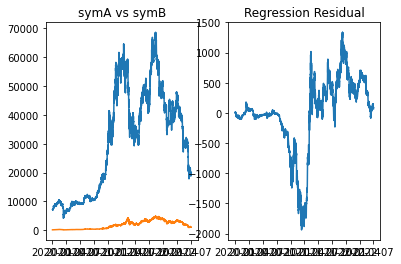

In [9]:
lm_model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
lm_model.fit(data[sym_a].values.reshape(-1,1), data[sym_b].values)        # fit() expects 2D array
print('parameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('symA vs symB')
ax[0].plot(data)
yfit = lm_model.coef_ * data[sym_a] + lm_model.intercept_
y_residual = data[sym_b] - yfit
ax[1].set_title('Regression Residual')
ax[1].plot(y_residual)
plt.show()

In [1]:
df = data['20210101':'20211231']
spread = df['BTCUSDT'] - df['ETHUSDT']
# fig,ax = plt.subplots(nrows=2, ncols=1)
ax[0].set_title('BTC & ETH Price')
ax[0].plot(df.index,df.BTCUSDT,color="red")
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("BTCUSDT Price",color="red",fontsize=10)
ax2=ax[0].twinx()
ax2.plot(df.index,df.ETHUSDT,color="blue")
ax2.set_ylabel("ETHUSDT Price",color="blue",fontsize=10)
plt.figure(figsize=(1000,20))
plt.show()
fig.savefig('BTC & ETH Price.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

NameError: name 'data' is not defined

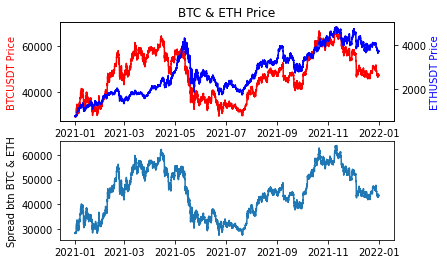

<Figure size 72000x1440 with 0 Axes>

In [10]:
df = data['20210101':'20211231']
spread = df['BTCUSDT'] - df['ETHUSDT']
fig,ax = plt.subplots(nrows=2, ncols=1)
ax[0].set_title('BTC & ETH Price')
ax[0].plot(df.index,df.BTCUSDT,color="red")
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("BTCUSDT Price",color="red",fontsize=10)
ax2=ax[0].twinx()
ax2.plot(df.index,df.ETHUSDT,color="blue")
ax2.set_ylabel("ETHUSDT Price",color="blue",fontsize=10)
# ax[1].set_title('Spread between BTC & ETH Price')
ax[1].plot(spread)
ax[1].set_ylabel("Spread btn BTC & ETH",fontsize=10)
plt.figure(figsize=(1000,20))
plt.show()
fig.savefig('BTC & ETH Price.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

## Hedge Ratio

/var/folders/r4/rjdyt00j2mz2mbj1synqs3vr0000gn/T/ipykernel_90241/612667122.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(str(p.date()) for p in data[::data.shape[0]//9].index)


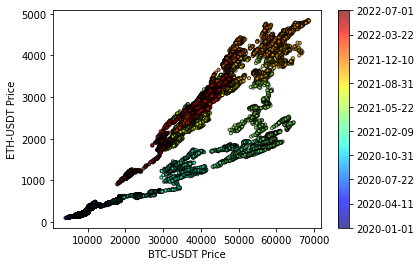

In [21]:
# color mapping
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, data.shape[0])
sc = plt.scatter(data[sym_a], data[sym_b], s=10, c=colors, cmap=cm, edgecolors='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels(str(p.date()) for p in data[::data.shape[0]//9].index)
plt.xlabel('BTC-USDT Price')
plt.ylabel('ETH-USDT Price')
plt.show()

/var/folders/r4/rjdyt00j2mz2mbj1synqs3vr0000gn/T/ipykernel_90241/2591999960.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(str(p.date()) for p in data[::data.shape[0]//9].index)


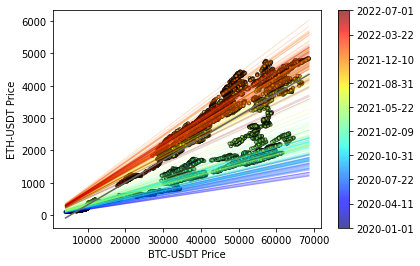

In [22]:
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, data.shape[0])
sc = plt.scatter(data[sym_a], data[sym_b], s=10, c=colors, cmap=cm, edgecolors='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels(str(p.date()) for p in data[::data.shape[0]//9].index)
plt.xlabel('BTC-USDT Price')
plt.ylabel('ETH-USDT Price')

step = 100
xi = np.linspace(data[sym_a].min()-5, data[sym_a].max()+5, 5)
colors_1 = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=0.2, lw=1, c=cm(colors_1[i]))

# plot the OLS regression for all data
plt.plot(xi, np.poly1d(np.polyfit(data[sym_a], data[sym_b], 1))(xi), '0.4')

plt.show()

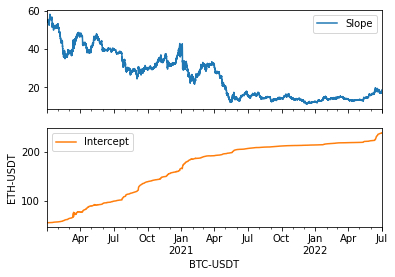

In [24]:
# kalman filter
state_cov_multiplier = np.power(0.01, 2)       # 0.1: spread_std=2.2, cov=16  ==> 0.01: 0.22, 0.16
observation_cov = 0.001
# observation matrix F is 2-dimensional, containing sym_a price and 1
# there are data.shape[0] observations
obs_mat_F = np.transpose(np.vstack([data[sym_b].values, np.ones(data.shape[0])])).reshape(-1, 1, 2)

kf = KalmanFilter(n_dim_obs=1,                                      # y is 1-dimensional
                  n_dim_state=2,                                    #  states (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),                    #  initial value of intercept and slope theta0|0
                  initial_state_covariance=np.ones((2, 2)),         # initial cov matrix between intercept and slope P0|0
                  transition_matrices=np.eye(2),                    # G, constant
                  observation_matrices=obs_mat_F,                   # F, depends on x
                  observation_covariance=observation_cov,                   # v_t, constant
                  transition_covariance= np.eye(2)*state_cov_multiplier)           # w_t, constant

state_means, state_covs = kf.filter(data[sym_a])                 # observes sym_b price
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]}, index=data.index)
beta_kf.plot(subplots=True)
plt.xlabel('BTC-USDT')
plt.ylabel('ETH-USDT')
plt.show()

In [14]:
from scipy.stats.stats import pearsonr
print('Pearson correlation coefficient:%.7f' %(pearsonr(data[sym_a], data[sym_b])[0]))

Pearson correlation coefficient:0.9024117


/var/folders/r4/rjdyt00j2mz2mbj1synqs3vr0000gn/T/ipykernel_90241/42568610.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [83]:
import statsmodels.tsa.stattools as ts
ts.adfuller(y_residual, 1)

(-2.925698153598086,
 0.04244022556525666,
 1,
 3934,
 {'1%': -3.432013338087558,
  '5%': -2.8622749717451534,
  '10%': -2.5671612338666803},
 -109553.69434931554)

In [68]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
jh_results = coint_johansen(data, 0, 1)             # 0 - constant term; 1 - log 1
print(jh_results.lr1)                           # dim = (n,) Trace statistic
print(jh_results.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
print(jh_results.evec)                          # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]

[10.95681438  1.58256378]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[[ 9.82856135e+01  9.75832710e+00]
 [-4.28066969e+05  1.03297396e+05]]


In [85]:
coint(data['DOGEUSDT'],data['SHIBUSDT'])

(-2.5856898321069868,
 0.24263797995194775,
 array([-3.89922537, -3.3376832 , -3.04552799]))

In [7]:
eth.head()

,const,ETHUSDT
open_time,,
2020-01-01 08:00:00,1.0,128.87
2020-01-01 09:00:00,1.0,130.64
2020-01-01 10:00:00,1.0,130.85
2020-01-01 11:00:00,1.0,130.20
2020-01-01 12:00:00,1.0,130.20


In [5]:
# Regress BTC on ETH
eth = sm.add_constant(eth)
result = sm.OLS(btc,eth).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                BTCUSDT   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                 9.600e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        23:58:46   Log-Likelihood:            -2.2730e+05
No. Observations:               21889   AIC:                         4.546e+05
Df Residuals:                   21887   BIC:                         4.546e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.007e+04     85.109    118.263      0.0